# Data Analysis

In [ ]:
# Import packages

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
from IPython.display import Audio

sys.path.append(os.path.abspath("../src"))
from data_loader import EmotionDataset, DatasetConfig
from utils.visualization import PlotSplitedDataHistogram

import warnings
warnings.filterwarnings ('ignore')
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings(action="ignore"):
    fxn()

In [8]:
# Parameters

DATA_ROOT = "D:\Projects\Technion\EmotionDetection\data"
SR = 6000 # 22050
FIX_SECS = 3
# MAX_FILES = 13000

## Data Info

For the Speech Emotion Recognition (SER) task, several widely used datasets provide diverse audio samples of spoken emotions. Each dataset has distinct characteristics in terms of actors, age ranges, accents, lexical content, and emotional categories. Understanding these differences is crucial for building robust models.

|                        | **RAVDESS** | **TESS** | **CREMAD** | **SAVEE** |
| ---------------------- | ----------- | -------- | ---------- | --------- |
| **Actors**             | 12 Male, 12 Female | 2 Female | 48 Male, 43 Female | 4 Male |
| **Ages**               | 20-60 | 26, 64 | 20-74 | 27-31 |
| **Lexical statements** | 2 | 200 | 12 | 15 |
| **Accent**             | North American | Canadian | African America, Asian, Caucasian, Hispanic | British |
| **Emotion types**      | neutral, calm, happy, sad, angry, fear, disgust, surprise | anger, disgust, fear, happy, surprise, sad, neutral | anger, disgust, fear, happy, neutral, sad | anger, disgust, fear, happy, sad, surprise, neutral |
| **Emotion intesity**   | normal, strong | single | low, medium, high | single |
| **Total samples**      | 1440 | 2800 | 74420 | 480 |


<br /><u>**Observations**</u>

* **Emotion coverage**: <br />All datasets cover core emotions (anger, happiness, sadness, fear, neutral). Some add disgust or surprise, making them complementary.
* **Intensity variation**: <br />RAVDESS and CREMA-D include multiple intensity levels, while TESS and SAVEE use single intensity recordings. This affects how models learn subtle emotional cues.
* **Sample size**: <br />CREMA-D is the largest, while SAVEE is the smallest. RAVDESS is unique for including both speech and song.
* **Demographics**: <br />CREMA-D stands out with diverse ethnic backgrounds, while SAVEE is limited to four British male speakers.


<br /><u>**Handling Strategy**</u><br />
To maximize recognition performance across these datasets:

1) **Emotion alignment**
    * Map emotion labels across datasets to a unified set (e.g., anger, happiness, sadness, fear, neutral).
    * Handle similar categories (e.g., calm and neutral in RAVDESS) by merging or excluding depending on experiment goals.

2) **Intensity normalization**
    * Standardize intensity levels (e.g., treat “normal/strong” and “low/medium/high” as comparable categories).
    * Consider collapsing intensities into a binary scale (low vs. high) for consistency.

3) **Sample balancing**
    * Use data augmentation (pitch shifting, noise injection, time stretching) to balance smaller datasets like SAVEE.
    * Apply class weighting or oversampling to reduce bias from larger datasets.

4) **Cross-dataset training**
    * Train models on combined datasets to improve generalization.
    * Evaluate performance separately on each dataset to measure robustness.

5) **Domain adaptation**
    * Use transfer learning or fine-tuning to adapt models trained on larger datasets (CREMA-D, RAVDESS) to smaller ones (SAVEE).



In [9]:
# Dataset of metadata

ds_cfg = DatasetConfig(
    data_root = DATA_ROOT
)
ds_work = EmotionDataset(ds_cfg)
print(f"Discovered {len(ds_work)} files.")

Discovered 12162 files.


In [11]:
ds = pd.DataFrame({
    "path": ds_work.paths,
    "dataset": ds_work.datasets,
    "emotion": ds_work.emotions,
    "intensity": ds_work.intensities
})
print(ds['dataset'].unique())
print(ds['emotion'].unique())
print(ds['intensity'].unique())
ds

['cremad' 'ravdess' 'savee' 'tess']
[4 6 5 2 0 3 1 7]
['single' 'high' 'low' 'middle' 'normal' 'strong']


,path,dataset,emotion,intensity
0,D:\Projects\Technion\EmotionDetection\data\cre...,cremad,4,single
1,D:\Projects\Technion\EmotionDetection\data\cre...,cremad,6,single
2,D:\Projects\Technion\EmotionDetection\data\cre...,cremad,5,single
3,D:\Projects\Technion\EmotionDetection\data\cre...,cremad,2,single
4,D:\Projects\Technion\EmotionDetection\data\cre...,cremad,0,single
...,...,...,...,...
12157,D:\Projects\Technion\EmotionDetection\data\tor...,tess,3,single
12158,D:\Projects\Technion\EmotionDetection\data\tor...,tess,3,single
12159,D:\Projects\Technion\EmotionDetection\data\tor...,tess,3,single
12160,D:\Projects\Technion\EmotionDetection\data\tor...,tess,3,single


### Emotion Alignment

In [5]:
# Get RAVDESS dataset only
ds_ravdess = ds.where((ds['dataset']=='ravdess')).dropna()

In [6]:
# Listen to a random neutral sample from RAVDESS
ds_ravdess_neutral = ds_ravdess.where((ds_ravdess['emotion']==0)).dropna()
ds_ravdess_neutral_sample = ds_ravdess_neutral.sample(n=1)
sample_path = ds_ravdess_neutral_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(77988,)

In [7]:
# Listen to a random calm sample from RAVDESS
ds_ravdess_calm = ds_ravdess.where((ds_ravdess['emotion']==1)).dropna()
ds_ravdess_calm_sample = ds_ravdess_calm.sample(n=1)
sample_path = ds_ravdess_calm_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(91967,)

In [8]:
# Listen to a random happy sample from RAVDESS
ds_ravdess_happy = ds_ravdess.where((ds_ravdess['emotion']==2)).dropna()
ds_ravdess_happy_sample = ds_ravdess_happy.sample(n=1)
sample_path = ds_ravdess_happy_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(97117,)

In [9]:
# Listen to a random sad sample from RAVDESS
ds_ravdess_sad = ds_ravdess.where((ds_ravdess['emotion']==3)).dropna()
ds_ravdess_sad_sample = ds_ravdess_sad.sample(n=1)
sample_path = ds_ravdess_sad_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(79460,)

In [10]:
# Listen to a random angry sample from RAVDESS
ds_ravdess_angry = ds_ravdess.where((ds_ravdess['emotion']==4)).dropna()
ds_ravdess_angry_sample = ds_ravdess_angry.sample(n=1)
sample_path = ds_ravdess_angry_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(87553,)

In [11]:
# Listen to a random fear sample from RAVDESS
ds_ravdess_fear = ds_ravdess.where((ds_ravdess['emotion']==5)).dropna()
ds_ravdess_fear_sample = ds_ravdess_fear.sample(n=1)
sample_path = ds_ravdess_fear_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(67688,)

In [12]:
# Listen to a random disgust sample from RAVDESS
ds_ravdess_disgust = ds_ravdess.where((ds_ravdess['emotion']==6)).dropna()
ds_ravdess_disgust_sample = ds_ravdess_disgust.sample(n=1)
sample_path = ds_ravdess_disgust_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(85345,)

In [13]:
# Listen to a random surprise sample from RAVDESS
ds_ravdess_surprise = ds_ravdess.where((ds_ravdess['emotion']==7)).dropna()
ds_ravdess_surprise_sample = ds_ravdess_surprise.sample(n=1)
sample_path = ds_ravdess_surprise_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(67688,)

In [14]:
# Get TESS dataset only
ds_tess = ds.where((ds['dataset']=='tess')).dropna()
# Listen to a random disgust sample from TESS
ds_tess_disgust = ds_tess.where((ds_tess['emotion']==6)).dropna()
ds_tess_disgust_sample = ds_tess_disgust.sample(n=1)
sample_path = ds_tess_disgust_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(48661,)

In [15]:
# Get CREMAD dataset only
ds_cremad = ds.where((ds['dataset']=='cremad')).dropna()
# Listen to a random disgust sample from CREMAD
ds_cremad_disgust = ds_cremad.where((ds_cremad['emotion']==6)).dropna()
ds_cremad_disgust_sample = ds_cremad_disgust.sample(n=1)
sample_path = ds_cremad_disgust_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(96382,)

<u>**Conclusion**</u><br/>
- **Calm** – This emotion is acoustically very close to *Neutral*, making it difficult to distinguish even by human perception. To avoid confusion during training and prevent the model from converging toward an ambiguous class, I have chosen to exclude *Calm* from the dataset rather than merge it with *Neutral*.


### Intensity normalisation

In [16]:
# Listen to a random normal sample from RAVDESS
ds_ravdess_normal = ds_ravdess.where((ds_ravdess['intensity']=='normal')).dropna()
ds_ravdess_normal_sample = ds_ravdess_normal.sample(n=1)
sample_path = ds_ravdess_normal_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(72839,)

In [17]:
# Listen to a random strong sample from RAVDESS
ds_ravdess_strong = ds_ravdess.where((ds_ravdess['intensity']=='strong')).dropna()
ds_ravdess_strong_sample = ds_ravdess_strong.sample(n=1)
sample_path = ds_ravdess_strong_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(85345,)

In [18]:
# Listen to a random low sample from CREMAD
ds_cremad_low = ds_cremad.where((ds_cremad['intensity']=='low')).dropna()
ds_cremad_low_sample = ds_cremad_low.sample(n=1)
sample_path = ds_cremad_low_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(55181,)

In [19]:
# Listen to a random middle sample from CREMAD
ds_cremad_middle = ds_cremad.where((ds_cremad['intensity']=='middle')).dropna()
ds_cremad_middle_sample = ds_cremad_middle.sample(n=1)
sample_path = ds_cremad_middle_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(55181,)

In [20]:
# Listen to a random high sample from CREMAD
ds_cremad_high = ds_cremad.where((ds_cremad['intensity']=='high')).dropna()
ds_cremad_high_sample = ds_cremad_high.sample(n=1)
sample_path = ds_cremad_high_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(41937,)

In [21]:
# Listen to a random single sample from CREMAD
ds_cremad_single = ds_cremad.where((ds_cremad['intensity']=='single')).dropna()
ds_cremad_single_sample = ds_cremad_single.sample(n=1)
sample_path = ds_cremad_single_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(44881,)

<u>**Conclusion**</u><br/>
Most samples in the datasets lack explicit intensity labels, and even those that are labeled do not consistently reflect a uniform scale of intensity. Because of this inconsistency, I have chosen not to normalize the data based on intensity values, ensuring that the training process focuses on emotion categories rather than unreliable intensity information.

In [22]:
ds_work.clean_data()
print(f"Discovered {len(ds_work)} files.")

ds = pd.DataFrame({
    "path": ds_work.paths,
    "dataset": ds_work.datasets,
    "emotion": ds_work.emotions,
    "intensity": ds_work.intensities
})
print(ds['dataset'].unique())
print(ds['emotion'].unique())
print(ds['intensity'].unique())

Discovered 11970 files.
['cremad' 'ravdess' 'savee' 'tess']
[3 5 4 1 0 2 6]
['single' 'high' 'low' 'middle' 'normal' 'strong']


### Class Balancing Analysis

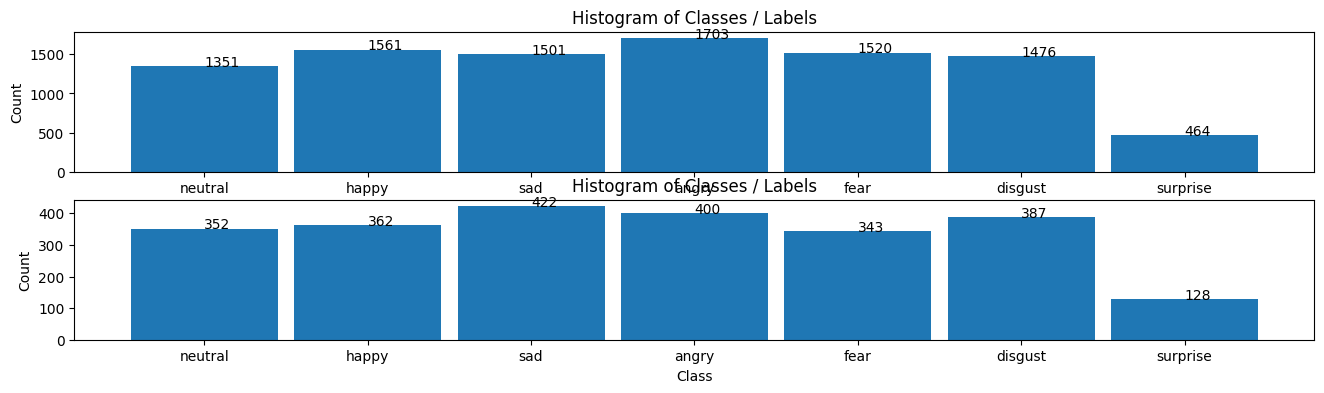

In [23]:
# Check label balances
train_fs, test_fs, train_labels, test_labels = train_test_split(ds_work.paths, ds_work.emotions, train_size = 0.8, random_state = 512)
labels_list = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
PlotSplitedDataHistogram(train_labels, test_labels, labels_list)

<u>**Conclusion**</u><br/>
In this section, we will analyze the class distribution in the dataset and identify any imbalances. Based on the analysis, we will oversample the underrepresented classes to achieve a balanced dataset. Augmentation will be deferred to later notebooks.

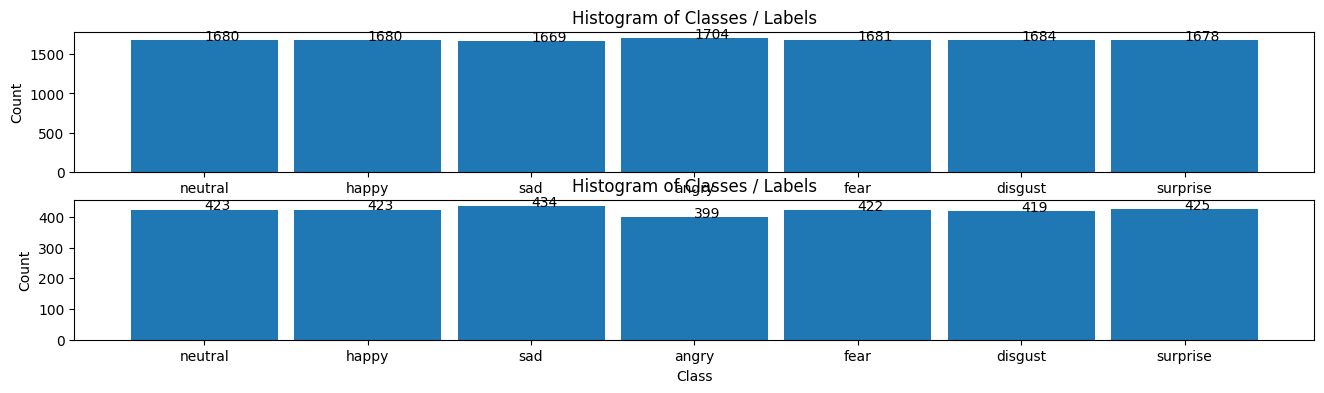

In [24]:
# Analyze class distribution
class_counts = ds['emotion'].value_counts()

# Oversample underrepresented classes
max_count = class_counts.max()

def oversample_class(df, target_class, target_count):
    class_df = df[df['emotion'] == target_class]
    oversampled_df = class_df.sample(target_count, replace=True, random_state=42)
    return oversampled_df

oversampled_data = pd.concat([
    oversample_class(ds, emotion, max_count) if count < max_count else ds[ds['emotion'] == emotion]
    for emotion, count in class_counts.items()
])

# Update the dataset with oversampled data
ds_oversampled = oversampled_data

# Check label balances
train_fs, test_fs, train_labels, test_labels = train_test_split(
    ds_oversampled['path'], ds_oversampled['emotion'], train_size=0.8, random_state=512
)
labels_list = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
PlotSplitedDataHistogram(train_labels, test_labels, labels_list)

### Audio Duration and Spectrogram Analysis

In this section, we will analyze the durations of audio files in the dataset to identify inconsistencies and outliers. Additionally, we will visualize spectrograms for a few samples to understand the frequency content of the audio data.

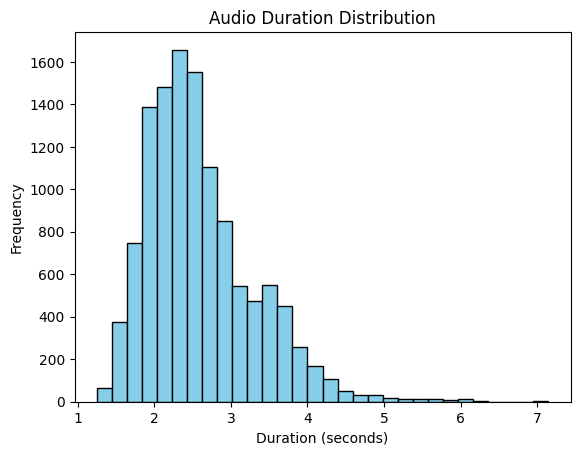

Detected 305 outliers based on duration.


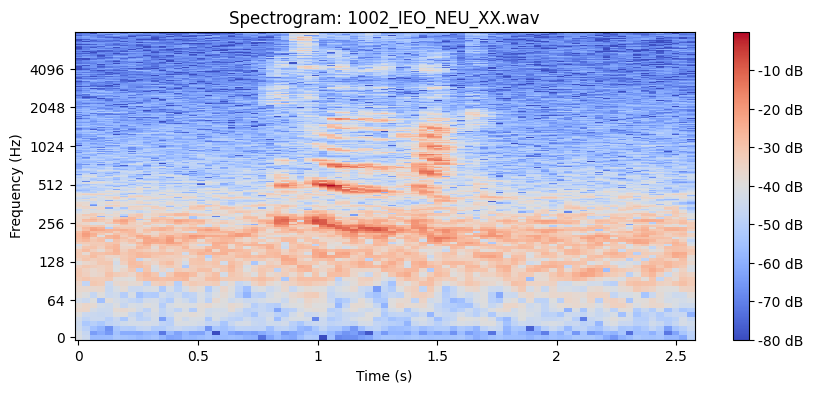

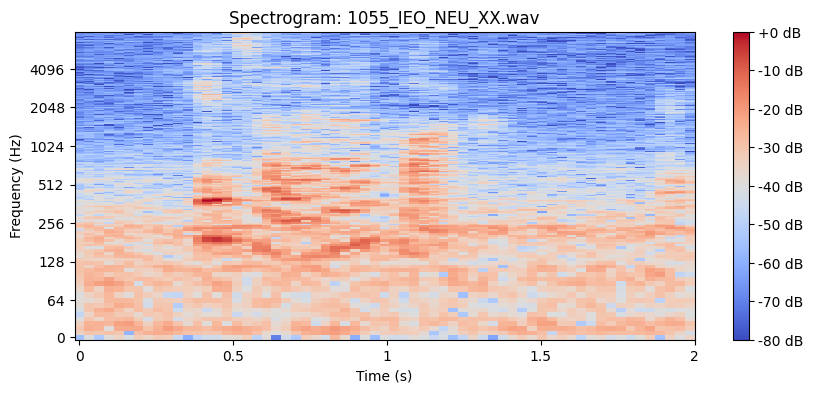

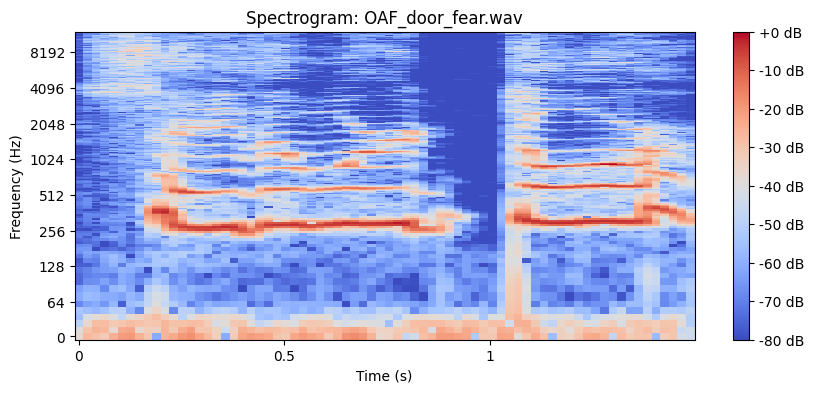

In [25]:
# Analyze audio durations
audio_durations = []
for path in ds_work.paths:
    audio, sr = librosa.load(path, sr=None)
    duration = librosa.get_duration(y=audio, sr=sr)
    audio_durations.append(duration)

# Plot duration distribution
plt.hist(audio_durations, bins=30, color='skyblue', edgecolor='black')
plt.title('Audio Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

# Detect outliers based on duration
q1 = np.percentile(audio_durations, 25)
q3 = np.percentile(audio_durations, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = [duration for duration in audio_durations if duration < lower_bound or duration > upper_bound]
print(f"Detected {len(outliers)} outliers based on duration.")

# Visualize spectrograms for a few samples
sample_paths = np.random.choice(ds_work.paths, size=3, replace=False)
for path in sample_paths:
    audio, sr = librosa.load(path, sr=None)
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram: {path.split(os.sep)[-1]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

<u>**Conclusion: Handling Varying Audio Durations**</u><br/>

To address the issue of varying audio durations, several methods were considered:

1. **Truncation**: Shorten all audio samples to a fixed duration. Simple but may lose important information.
2. **Padding**: Extend shorter samples with zeros or noise. Retains information but introduces artificial data.
3. **Resampling**: Adjust all samples to a fixed number of frames. Retains information but may distort signals.
4. **Sliding Windows**: Extract fixed-size segments using a sliding window. Retains all information and is suitable for real-time processing.
5. **Variable Input Models**: Use models that handle variable-length inputs. Avoids preprocessing but requires more complex architectures.

**Selected Method**: Sliding windows were chosen as the preferred method. This approach ensures fixed-size inputs while retaining all audio information. It is also well-suited for the next milestone of real-time inference on edge devices.

### Optimal Sample Rate Analysis

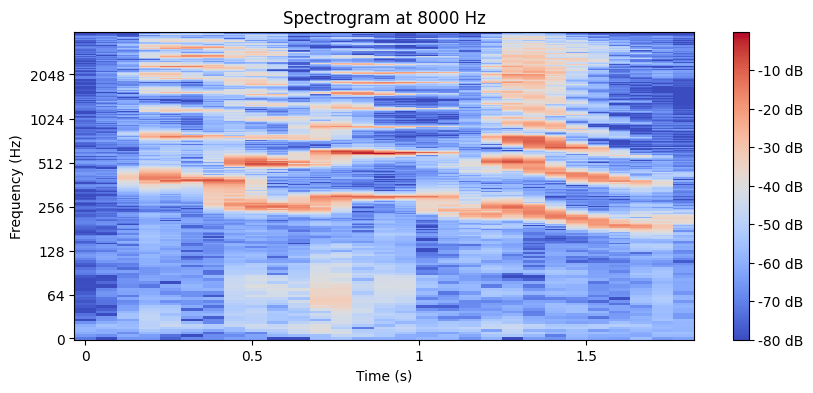

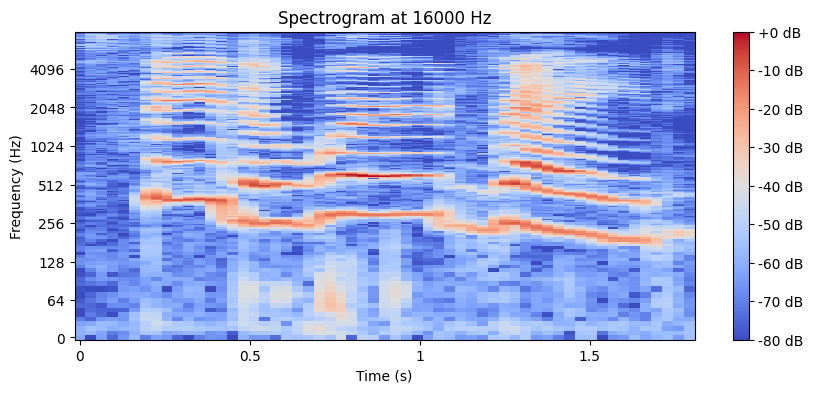

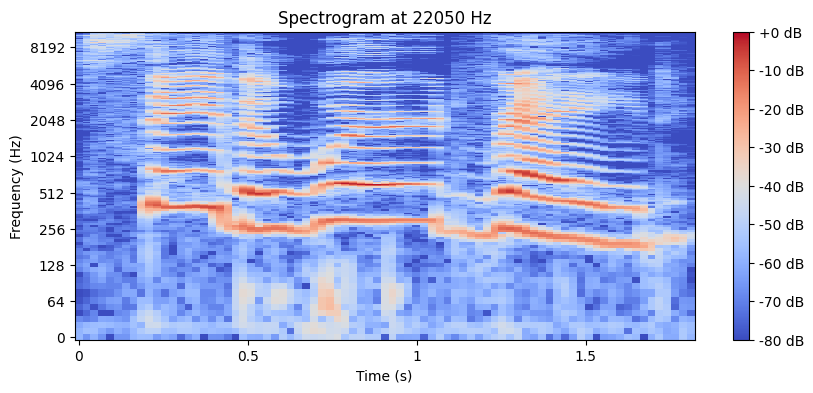

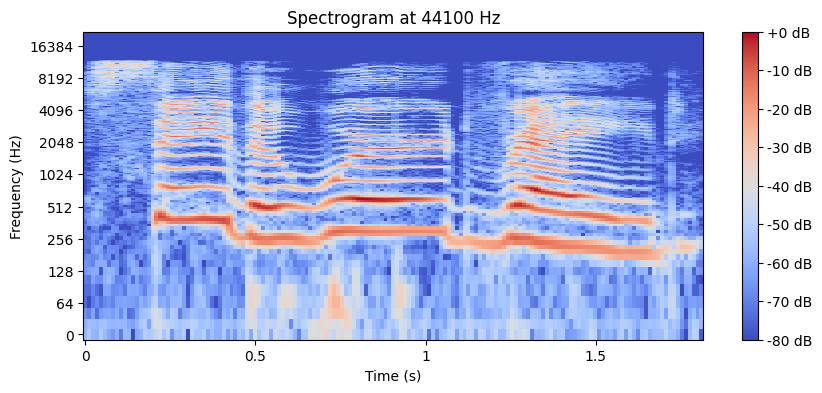

Memory usage at different sample rates:
8000 Hz: 0.03 MB
16000 Hz: 0.06 MB
22050 Hz: 0.08 MB
44100 Hz: 0.15 MB


In [36]:
# Analyze optimal sample rate
import librosa.display

# Define sample rates to test
sample_rates = [8000, 16000, 22050, 44100]

# Select a random audio sample
sample_path = np.random.choice(ds_work.paths, size=1, replace=False)[0]

# Analyze frequency content at different sample rates
for sr in sample_rates:
    audio, _ = librosa.load(sample_path, sr=sr)
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram at {sr} Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

# Calculate memory usage for each sample rate
def calculate_memory_usage(duration, sr):
    return duration * sr * 2 / (1024 ** 2)  # Assuming 16-bit PCM, 2 bytes per sample

audio, original_sr = librosa.load(sample_path, sr=None)
duration = librosa.get_duration(y=audio, sr=original_sr)

print("Memory usage at different sample rates:")
for sr in sample_rates:
    memory = calculate_memory_usage(duration, sr)
    print(f"{sr} Hz: {memory:.2f} MB")

<u>**Conclusion: Selected Sample Rate**</u><br/>

Based on the analysis of spectrograms and memory usage, a sample rate of **16 kHz** has been chosen as the default for further experiments. This rate balances memory efficiency and retention of critical audio information for emotion detection.

However, the sample rate will remain configurable to allow testing its impact during training. This flexibility ensures that the model can be optimized for different scenarios if needed.

### Correlation Analysis

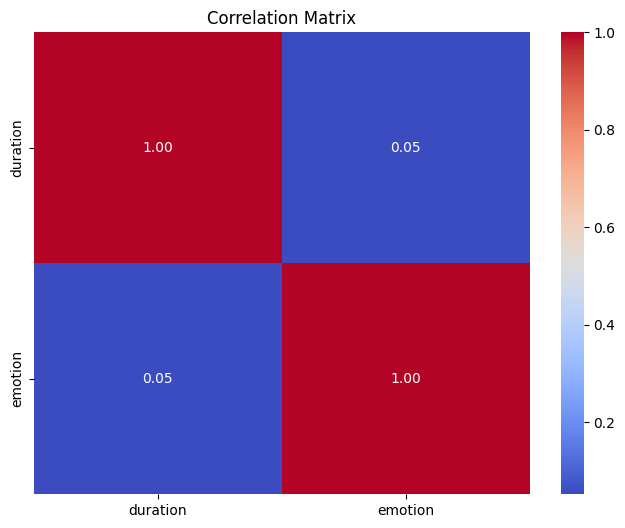

In [12]:
# Correlation Analysis
import seaborn as sns

# Select numerical features for correlation analysis
numerical_features = ['duration']

# Add duration to the dataset
audio_durations = []
for path in ds_work.paths:
    audio, sr = librosa.load(path, sr=None)
    duration = librosa.get_duration(y=audio, sr=sr)
    audio_durations.append(duration)

ds['duration'] = audio_durations

# Compute correlation matrix
correlation_matrix = ds[numerical_features + ['emotion']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

<u>**Conclusion: Duration and Emotion Detection**</u><br/>

Based on the correlation analysis, the duration of audio samples does not significantly influence emotion detection. This finding suggests that duration can be excluded as a feature in future modeling efforts, allowing the focus to remain on more impactful features such as frequency content and intensity.

### Data Normalization Analysis

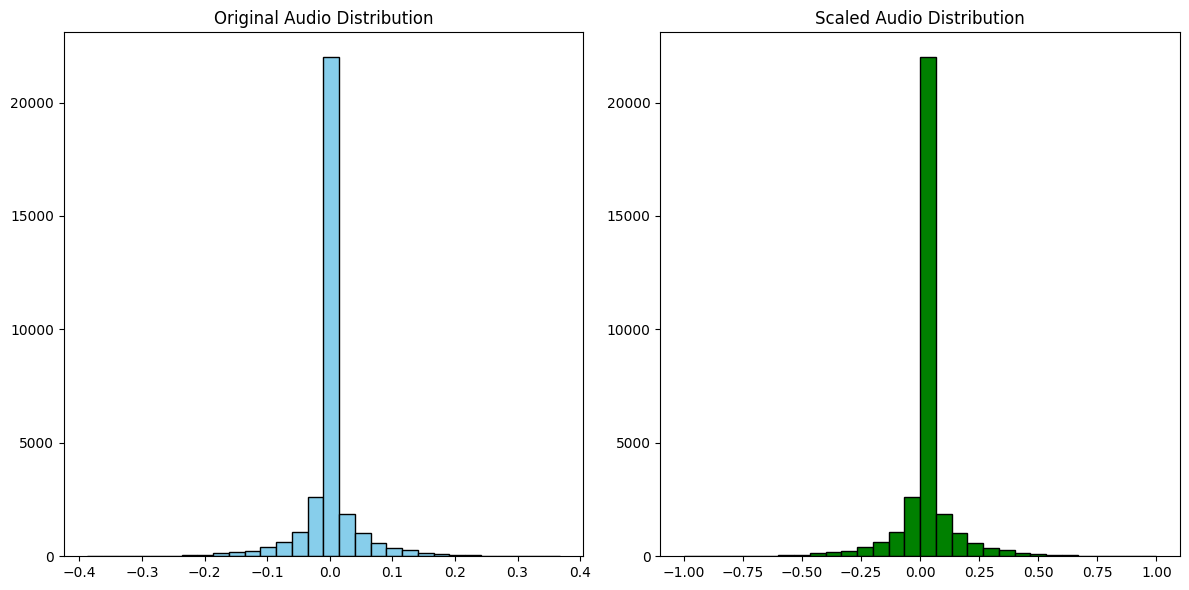

In [19]:
# Scale raw audio data without altering mean
import librosa

# Example: Scale raw audio signals to [-1, 1] without changing mean
scaled_audio_data = []
subset_paths = ds_work.paths[:10]  # Limit to 10 files for testing
for path in subset_paths:
    audio, sr = librosa.load(path, sr=None, duration=5)  # Load only 5 seconds of audio
    audio_min = audio.min()
    audio_max = audio.max()
    scaled_audio = 2 * (audio - audio_min) / (audio_max - audio_min) - 1  # Scale to [-1, 1]
    scaled_audio_data.append(scaled_audio)

# Compare distributions before and after scaling
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(audio, bins=30, color='skyblue', edgecolor='black')
plt.title('Original Audio Distribution')

plt.subplot(1, 2, 2)
plt.hist(scaled_audio, bins=30, color='green', edgecolor='black')
plt.title('Scaled Audio Distribution')

plt.tight_layout()
plt.show()

# Decision: Evaluate if scaling improves feature extraction and model performance

<u>**Conclusion: Impact of Scaling**</u><br/>

Scaling raw audio data to the range [-1, 1] ensures consistency in input features without altering the mean. This preprocessing step can enhance the stability of feature extraction methods and improve model performance by standardizing the dynamic range of audio signals. Further evaluation is needed to confirm its impact on downstream tasks.

### Summary Table: Conclusions and Decisions

| **Aspect**                | **Conclusion**                                                                 | **Decision**                                                                 |
|---------------------------|-------------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| Emotion Alignment         | Calm is acoustically close to Neutral, causing ambiguity.                     | Exclude Calm from the dataset to avoid confusion during training.           |
| Intensity Normalization   | Intensity labels are inconsistent across datasets.                             | Avoid normalization based on intensity; focus on emotion categories.        |
| Audio Duration Handling   | Varying durations observed; sliding windows retain all information.            | Use sliding windows for fixed-size inputs, suitable for real-time inference.|
| Sample Rate Selection     | 16 kHz balances memory efficiency and audio quality.                           | Set 16 kHz as the default sample rate for experiments.                      |
| Data Scaling              | Scaling to [-1, 1] ensures consistency without altering mean.                  | Standardize audio signals to [-1, 1] for stable feature extraction.         |
| Class Balancing           | Imbalances observed in emotion classes.                                        | Oversample underrepresented classes to achieve balance.                     |
| Correlation Analysis      | Duration does not significantly influence emotion detection.                   | Exclude duration as a feature in modeling.                                  |

This table summarizes the key findings and decisions made during the data exploration and preprocessing phase. These steps ensure the dataset is well-prepared for training robust emotion detection models.